# Experimentation 3: Seizure Detection

## Structure
1. Data preparation (pre-processing)<br/>
   Note: ideally you store the pre-processed data in template 02 and load it here again, instead of duplicating the code …
2. Windowing
3. Feature & label extraction
4. Data split
5. FV-pre-processing
6. Classifier creation
7. Evaluation


## Reporting
Not every plot or number generated in this template comes into the report.
Nonetheless, some intermediary steps are required to achieve the relevant results.
Cells, which have a *direct* relation to a part of the report, 
are marked with **Report:**.
Be sure to not jump over relevant precursor steps.
But when having little time, think about your priorities, and try to avoid spending time on decorative steps or cells which are not needed for the report.

The relevant information about what to include in the report is the corresponding pdf document on itslearning.
Annotations in this file are just for orientation and might not be complete.



## What to do
  - Build it up step by step, i.e
      * First take a short look at how the pipeline looks like
      * Initially, use the raw window as feature vector for starters to get everything going
      * Implement the overlap of the window with the seizure,
        so that you have a label
      * Only then start implementing features
      * Then, you can go on
  - There are many parameters which influence the outcome
      * Which influence does balancing have?
      * How about scaling?
      * And PCA with / without whitening?
      * Try to get a feeling for how the PCA changes the channels, 
        i.e., plot consecutive channels on x/y axis.
        Colour the dots according to their labels.
      * How do your observations relate to your expectations?
  - Investigate the relevance of features
  - Without doing a proper evaluation, do you think that the relevance of the features correlates with the computaton time going into deriving them?
  
## Discussion
In your group or with your neighbours
- Which influence does the data preparation have? I.e., normalisation, PCA, whitening?
- When comparing the use of PCA here to Module 2, how would you describe the interpretability of the dimensions?
- Which performance do you achieve? Is the detector usable?
- Reflecting on the performance of the detector, for which tasks would you trust this model? How would you like to change the performance for possible use cases?

## When you are done with all other tasks…
You can check template 3a for optional tasks to dig deeper.

In [1]:
!pip install pyedflib pathlib numpy

In [18]:
from pyedflib import highlevel
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.signal import windows
from scipy import fft
from sklearn import preprocessing, svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from numpy.random import default_rng



# Jupyter lab supports interactive plots      # Matplotlib for plotting
# using "widget"
%matplotlib widget

# Jupyter lab doesn't support notebook,
# which was the preferred method for jupyter notebooks.
#%matplotlib notebook
#%matplotlib inline


from matplotlib import pyplot as plt
from matplotlib import patches

# Adjust plot size & resolution for inline display.
# Tune to your needs.
plt.rcParams['figure.figsize'] = [9, 5.56]
plt.rcParams['figure.dpi'] = 100

In [50]:
# Defining base paths for read-only and read-write data
# will make it easy for us to switch between cloud
# and local environments by just adjusting the paths.
#
# Also, it will prevent accidental overwriting of read-only data.
#
# The example codes starting with '/work' relate to UCloud.
# Note that jupyterlab in ucloud will not show you the /work folder.
# What jupyterlab shows as origin */* of the filesystem
# is in reality the */work* folder.

from pathlib import Path         # OS agnostic path handling (/ vs \)

user = 'jb'                      # Per-user output directories

# Base directories
# DATA_DIR -- where the read-only sources are
DATA_DIR = Path('./data')

# OUTPUT_DIR -- where we will keep our data (read/write)
# We will make sure it exists!
OUTPUT_DIR = Path('./output')

# Now create our own output directory and change to it
OUTPUT_DIR /= user
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Hyper parameters for the data analysis
USE_RAW_WINDOW_AS_FEATURE = False
DO_BALANCING = False
NON_SEIZURE_OVERHEAD = 1.1
SCALING_METHOD = 'robust'
DO_PCA = True
PCA_WHITEN = False
PCA_N_COMP = 'mle'


import os
#os.chdir(OUTPUT_DIR)             # Change working directory

# Loading the Data
While this template replicates the boxes from template 02, it is advised to store the pre-processed data in template 02 and then load it again here, preventing you from duplicating all the code.

In [51]:
# Loading file:
fn = './module_3/data/seizure_eeg_data/' \
     '01.edf'
import os
print(os.listdir("."))
print(os.getcwd())
print('Reading EEG from: {}'.format(fn))

raw_signals, signal_headers, header = \
    highlevel.read_edf(str(fn))

['.ipynb_checkpoints', 'precision_recall_hyperparameter_comparison.png', '.ucviz-data', 'model.pth', 'job-0.sh', 'combined_metrics_vs_gamma.png', 'f1_jaccard_vs_gamma.png', 'segmentation_unet_membrane.ipynb', 'data', 'module_3', 'JobParameters.json', 'output', 'stdout-0.log', 'module_2_-_image_processing', 'precision_recall_vs_gamma.png', '.ucviz-ui']
/work
Reading EEG from: ./module_3/data/seizure_eeg_data/01.edf


In [52]:
# Annotations:
# In seconds since start of recording,
# use singal_headers.sample_frequency to map to sample numbers
seizures = list()
for start, duration, kind in header['annotations']:
    if kind == 'Seizure':
        seizures.append((start, float(duration)))
print(f"Found {len(seizures)} seizure annotations.")


Found 80 seizure annotations.


In [53]:
# For easier referencing of a specific channel:
# A lookup table with the labels of all channels in the edf
channel_labels = {sh['label']: i for i, sh in enumerate(signal_headers)}

for i, sh in enumerate(signal_headers):
    print('Channel {:2d}: {}'.format(i, sh['label']))

Channel  0: EEG Fp1-REF
Channel  1: EEG Fp2-REF
Channel  2: EEG F3-REF
Channel  3: EEG F4-REF
Channel  4: EEG C3-REF
Channel  5: EEG C4-REF
Channel  6: EEG P3-REF
Channel  7: EEG P4-REF
Channel  8: EEG O1-REF
Channel  9: EEG O2-REF
Channel 10: EEG F7-REF
Channel 11: EEG F8-REF
Channel 12: EEG T3-REF
Channel 13: EEG T4-REF
Channel 14: EEG T5-REF
Channel 15: EEG T6-REF
Channel 16: EEG Zyg_1-REF
Channel 17: EEG Zyg_2-REF
Channel 18: EEG Fz-REF
Channel 19: EEG Cz-REF
Channel 20: EEG Pz-REF
Channel 21: EEG F10-REF
Channel 22: EEG F9-REF
Channel 23: EEG P9-REF
Channel 24: ECG EKG1-REF
Channel 25: EEG P10-REF
Channel 26: EMG_4-REF
Channel 27: Photic-REF


# Pre-Processing & Preparation

## Filtering
Take from Task 2, or load pre-processed data from file.
Note that you need to filter all channels.

In [54]:
# TODO: REPLACE the following line of code!
#       There is no need to keep it.
# Nah, this is a perfect solution for now :)
signals = raw_signals.copy()

## Per-channel normalisation
The signals have per definition a zero line.
The easiest way to go on is therefore to scale symmetrically.
Note though that this is a plump assumption and should be replaced by
transforming to physical units first.

Why do we normalise here?
Well, we don't have to, but it is especially helpful for methods includig probability density function (pdf) estimation (Optional Tasks 3a).

In [55]:
# We need to pass the values on to a new variable,
# even if we by default do not filter the normalise
# the signal here.
norm_signals = None

# Change to True to perform normalisation here.
if False:
    norm_signals = np.zeros((signals.shape[0] - 1, signals.shape[1]))
    for i in range(signals.shape[0] - 1):
        # Using variance should not be that sensitive to outliers as the maximum.
        # But both perform good. For pdf estimation use max of absolute value.
        #scaling_factor = 2 * np.sqrt(np.var(signals[i,:]))
        scaling_factor = np.max(np.abs(signals[i,:]))
        if scaling_factor == 0:
            print('Channel #{} has no content!'.format(i))
        norm_signals[i,:] = signals[i,:] / scaling_factor
else:
    norm_signals = signals.copy()

## Windowing function & overlap with seizure
There are library functions which also do this.
This implementaion is rather raw, but illustrates the idea.

We analyse the time series in terms of windows. Given a signal + header,
we can configure the window length + overlap.

In [56]:
from scipy.signal import windows
    
def interval_overlap(i1_start : float, i1_stop : float,
            i2_start : float, i2_stop : float) -> float: 
    window_duration = i1_stop - i1_start
    if window_duration == 0:
        return 0

    # Determine the intersection of the two intervals
    overlap_start = max(i1_start, i2_start)
    overlap_end = min(i1_stop, i2_stop)

    # Calculate the duration of the overlap
    overlap_duration = max(0, overlap_end - overlap_start)

    return overlap_duration / window_duration


def overlap_with_seizures(i1_start: float, i1_duration: float) -> float:
    """Determine the total overlap of a given interval with all annotated seizures."""
    total_overlap = 0
    for s_start, s_duration in seizures:
        # The sum of overlaps is capped at 1, as a window can't be >100% seizure. Which is may be from the normalization
        total_overlap += interval_overlap(i1_start, i1_start + i1_duration,
                                          s_start, s_start + s_duration)
    return min(total_overlap, 1.0)

# Feature extraction
For each window in each channel, we will generate a feature vector.
The label will be determined by the overlap with the seizure annotation.

General procedure:
 1. Per-channel normalisation
 2. Window splitting (time, signal, overlap of window with seizure annotation)
 3. Calculation of features
 4. Store: (time, features, label == overlap)
 
I suggest to implement at least the following features
  * mean
  * variance
  * energy
  * area
  * nonlinear_energy
  * num_zero_crossings
  * length_of_curve

Please check with the lecture to get a detailed list of what is expected for a minimal implementation.

**Report:** Part 3.3

## Code for Calculating Features
Of course, with more complex features, you are free to map this in the notebook structure.

In [57]:
def time_windows(signal, header, window_length_in_s, overlap_in_s):
    """
    Iterator that yields time windows from a signal.

    For each window, it yields its center time, the signal data,
    and its seizure overlap label.
    """
    rate = header['sample_frequency']
    window_length_in_samples = int(window_length_in_s * rate)
    overlap_in_samples = int(overlap_in_s * rate)
    step = window_length_in_samples - overlap_in_samples

    for i in range(0, len(signal) - window_length_in_samples + 1, step):
        window_start_time_s = i / rate
        window_center_time_s = (i + window_length_in_samples / 2) / rate
        
        yield (window_center_time_s,
               signal[i:i + window_length_in_samples],
               overlap_with_seizures(window_start_time_s, window_length_in_s))



def get_spectral_power(signal, fs, band):
    """Calculate the power in a specific frequency band."""
    # Using rfft for efficiency with real signals
    fft_vals = np.abs(fft.rfft(signal))**2
    freqs = fft.rfftfreq(len(signal), 1.0/fs)
    
    # Find indices corresponding to the frequency band
    band_indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    
    # Sum the power in the band
    return np.sum(fft_vals[band_indices])

## Forming the Feature Vector
Here, you actually plug in the features you want to include in the feature vector.

In [58]:
def build_feature_vector(sig, fs):
    """
    Creates a feature vector from a signal window.
    
    Features:
    1. Line Length: Captures complexity and amplitude.
    2. Energy: Captures signal strength.
    3-7. Spectral Power in different bands.
    """
    # Time-domain features
    line_length = np.sum(np.abs(np.diff(sig)))
    energy = np.sum(sig**2)
    
    # Frequency-domain features
    power_delta = get_spectral_power(sig, fs, [0.5, 4])
    power_theta = get_spectral_power(sig, fs, [4, 8])
    power_alpha = get_spectral_power(sig, fs, [8, 13])
    power_beta = get_spectral_power(sig, fs, [13, 30])
    power_gamma = get_spectral_power(sig, fs, [30, 80])
    
    return np.array([
        line_length,
        energy,
        power_delta,
        power_theta,
        power_alpha,
        power_beta,
        power_gamma
    ])


# We derive the number of features automatically
# by calling build_feature_vector with fake data.
# Determine the number of features

# Moving windows up here to use them for the feature utilization
# Describe the performance influence of window sizes
window_length = 3  # seconds
window_overlap = 2  # seconds. High overlap helps get more seizure samples.

# Use the first channel to determine sizes and pre-allocate arrays
first_header = signal_headers[0]
fs = first_header['sample_frequency']
window_length_in_samples = int(window_length * fs)
overlap_in_samples = int(window_overlap * fs)

num_features = 0

if USE_RAW_WINDOW_AS_FEATURE:
    num_features = window_length_in_samples
    print(f"Using RAW window as feature vector. Num features per channel: {num_features}")
else:
    # Derive the number of features automatically by calling build_feature_vector
    num_features = len(build_feature_vector(np.linspace(0, 19, 20), fs)) #why do we do this?
print(f"Using ENGINEERED features. Num features per channel: {num_features}")
print('Number of features per fv:', num_features)

Using ENGINEERED features. Num features per channel: 7
Number of features per fv: 7


## Processing the Data
Now perform the feature calculations and collect the feature vectors for all windows.

**Report:** Part 3.3

In [59]:
# Per channel window splitting & feature vector creation
# Optimisation options:
#   * Save all windows, so that we can calculate features without window regeneration!
#   * Extract windows for all channels at the same time

# Calculate total number of windows to pre-allocate memory
num_channels = signals.shape[0]
num_windows = int(np.floor(
    (signals.shape[1] - window_length_in_samples) / (window_length_in_samples - overlap_in_samples)
)) + 1
fv_times = np.zeros((num_windows))
fvs = np.zeros((num_windows, num_channels * num_features))
labels = np.zeros((num_windows))

for ch_idx in range(num_channels):
    print(f'  Extracting features for Channel #{ch_idx+1}/{num_channels}', end='\r')
    ch_header = signal_headers[ch_idx]
    ch_signal = signals[ch_idx]
    
    for win_idx, (start_time, win_data, overlap) in enumerate(
        time_windows(ch_signal, ch_header, window_length, window_overlap)):
        
        if win_idx >= num_windows: continue # Should not happen with correct calculation

        # Calculate feature vector for the current window
        if USE_RAW_WINDOW_AS_FEATURE:
            feature_vec = win_data
        else:
            feature_vec = build_feature_vector(win_data, fs)#ask gemini
        
        # Place the features in the correct block of the matrix
        fvs[win_idx, ch_idx * num_features:(ch_idx + 1) * num_features] = feature_vec
        
        # Labels and times are the same for all channels, so only set them once
        if ch_idx == 0:
            fv_times[win_idx] = start_time
            # Label is 1 if there's any seizure overlap, 0 otherwise
            labels[win_idx] = 1 if overlap > 0.1 else 0

print(num_windows)
print(num_channels, num_features, num_channels * num_features)
print(fvs.shape)

print("\nFeature extraction complete.")
print(f"Feature matrix shape: {fvs.shape}")

7204tracting features for Channel #28/28
28 7 196
(7204, 196)

Feature extraction complete.
Feature matrix shape: (7204, 196)


# Classification
Now comes the time to throw the feature vectors at different classifiers.
But as we do not have the time to go into all the different options, we will stick to the logistic regression, which we know from Module 2 as a possible choice for classification tasks.

**Report:** Part 3.3

## Data Set Splitting
While there are plenty of methods available to automate this part, we are here going to do it by hand, so that we can experiment with the process, i.e., you definitely want to fiddle with the balancing.

**Report:** Part 3.3

In [60]:
test_split = 0.8  # 80% for training, 20% for testing
binary_labels = labels > 0

# Indices for seizure and non-seizure windows
seizure_idx = np.where(binary_labels == 1)[0]
interictal_idx = np.where(binary_labels == 0)[0]

print(f"\nTotal windows: {len(labels)}. Seizure: {len(seizure_idx)}, Non-Seizure: {len(interictal_idx)}")

train_data_raw, train_labels = None, None
test_data_raw, test_labels = None, None

if DO_BALANCING:
    print("Balancing dataset by undersampling non-seizure class...")
    rng = default_rng(42) # for reproducibility
    
    num_seizure_fvs = len(seizure_idx)
    num_train_seizure = int(round(test_split * num_seizure_fvs))
    
    # Shuffle indices to ensure random selection
    rng.shuffle(seizure_idx)
    rng.shuffle(interictal_idx)
    
    # Select seizure indices for train/test
    train_s_idx = seizure_idx[:num_train_seizure]
    test_s_idx = seizure_idx[num_train_seizure:]
    
    # Select a corresponding number of non-seizure indices
    num_train_interictal = int(num_train_seizure * NON_SEIZURE_OVERHEAD)
    train_i_idx = interictal_idx[:num_train_interictal]
    # Use the rest for testing
    test_i_idx = interictal_idx[num_train_interictal:]
    
    # Combine and shuffle training and testing indices
    train_idx = np.concatenate((train_s_idx, train_i_idx))
    test_idx = np.concatenate((test_s_idx, test_i_idx))
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)
    
    train_data_raw = fvs[train_idx, :]
    train_labels = binary_labels[train_idx]
    test_data_raw = fvs[test_idx, :]
    test_labels = binary_labels[test_idx]
else:
    print("Using imbalanced dataset with a simple chronological split...")
    split_point = int(test_split * len(binary_labels))
    train_data_raw = fvs[:split_point, :]
    train_labels = binary_labels[:split_point]
    test_data_raw = fvs[split_point:, :]
    test_labels = binary_labels[split_point:]

print(f"Training set: {train_data_raw.shape[0]} samples. Seizure: {sum(train_labels)} ({sum(train_labels)/len(train_labels):.1%})")
print(f"Testing set:  {test_data_raw.shape[0]} samples. Seizure: {sum(test_labels)} ({sum(test_labels)/len(test_labels):.1%})")



Total windows: 7204. Seizure: 285, Non-Seizure: 6919
Using imbalanced dataset with a simple chronological split...
Training set: 5763 samples. Seizure: 235 (4.1%)
Testing set:  1441 samples. Seizure: 50 (3.5%)


## Last Pre-Processing & PCA
In this part, we investigate the improvements by using scaling and PCA for reducig dimensions and decorrelating signals.
Please check [the scikit documentation on pre-processing](https://scikit-learn.org/stable/modules/preprocessing.html) for details on how the following settings are transforming the data.

**Report:** Part 3.3

In [49]:
print("\nStarting pre-processing...")
print(f"Original dimensionality: {train_data_raw.shape[1]}")

# Scaling - describe performance influence of balancing techniques. 
if SCALING_METHOD == 'standard':
    print("Applying StandardScaler.")
    scaler = preprocessing.StandardScaler().fit(train_data_raw)
elif SCALING_METHOD == 'robust':
    print("Applying RobustScaler (good for data with outliers).")
    scaler = preprocessing.RobustScaler().fit(train_data_raw)
else:
    print("No scaling applied.")
    scaler = preprocessing.FunctionTransformer() # Dummy scaler

train_data = scaler.transform(train_data_raw)
test_data = scaler.transform(test_data_raw)

# PCA - describe performance influence of PCA and whitening (with and without)
if DO_PCA:
    print(f"Performing PCA (whiten={PCA_WHITEN}, n_components={PCA_N_COMP})...")
    pca = PCA(n_components=PCA_N_COMP, svd_solver='full', whiten=PCA_WHITEN, copy=True)
    pca.fit(train_data)
    train_data = pca.transform(train_data)
    test_data = pca.transform(test_data)
    print(f"PCA complete. New dimensionality: {pca.n_components_}")
    print(f"  Variance explained by first 4 components: {pca.explained_variance_ratio_[:4].round(3)}")



Starting pre-processing...
Original dimensionality: 196
Applying RobustScaler (good for data with outliers).
Performing PCA (whiten=False, n_components=mle)...
PCA complete. New dimensionality: 189
  Variance explained by first 4 components: [0.626 0.228 0.072 0.046]


## Optional: Inspecting the PCA's Effect
For trying to get a feeling for how the PCA changes the channels, please plot consecutive or two otherwise selected channels on x/y axis.
Colour the dots according to their labels.

Can you find dimensions which separate the labels better than others?
Keep them in mind when checking later the relevance of the features.

This part is for trying to get a feeling of how the PCA might help the classifier,
it is an explorative task, which means trying out, plotting, and inspecting.
Do this only after you have completed your report, to avoid getting stuck here.

# Create a Model
**Report:** Part 3.3

In [31]:
#from sklearn.linear_model import LogisticRegression

#classifier = LogisticRegression()

# using random forest insted

train_data = scaler.transform(train_data_raw)
test_data = scaler.transform(test_data_raw)

# PCA - describe the performance influence in the report. 
if DO_PCA:
    # Random Forest classifier is largely insensitive to the whiten feature scaling that PCA whitening performs.
    print(f"Performing PCA (whiten={PCA_WHITEN}, n_components={PCA_N_COMP})...")
    pca = PCA(n_components=PCA_N_COMP, svd_solver='full', whiten=PCA_WHITEN, copy=True)
    pca.fit(train_data)
    train_data = pca.transform(train_data)
    test_data = pca.transform(test_data)
    print(f"PCA complete. New dimensionality: {pca.n_components_}")
    print(f"  Variance explained by first 4 components: {pca.explained_variance_ratio_[:4].round(3)}")


Performing PCA (whiten=False, n_components=mle)...
PCA complete. New dimensionality: 189
  Variance explained by first 4 components: [0.637 0.199 0.037 0.035]


In [32]:
# Fit the model
#classifier.fit(train_data, train_labels)

# Evaluation
Evaluate accuracy, sensitivity, specificity, confusion matrix.
What do these measures tell us about the performance of our model?

Check which features were most relevant.

**Report:** Part 3.3


Training Random Forest Classifier...
Evaluating classifier...

Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.99      1.00      1.00      1391
     Seizure       1.00      0.84      0.91        50

    accuracy                           0.99      1441
   macro avg       1.00      0.92      0.96      1441
weighted avg       0.99      0.99      0.99      1441



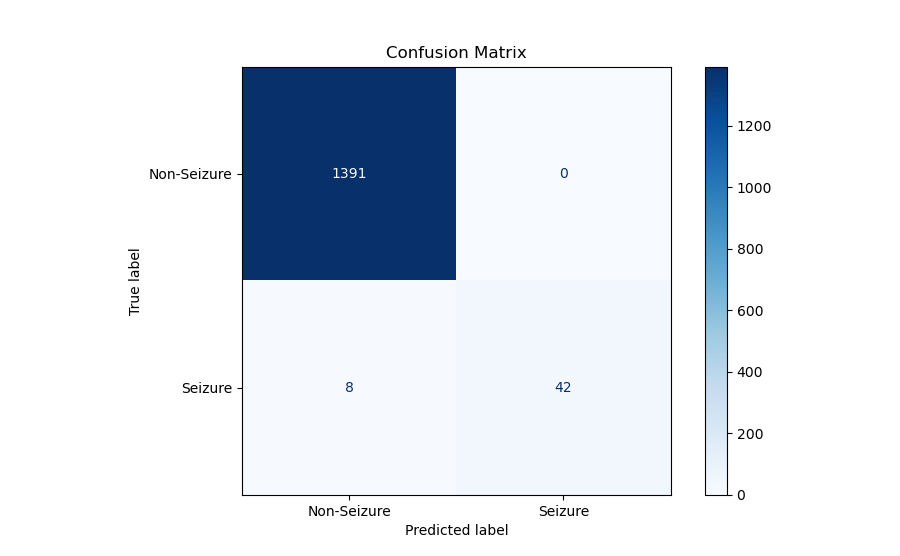

 PCA_WHITEN: False


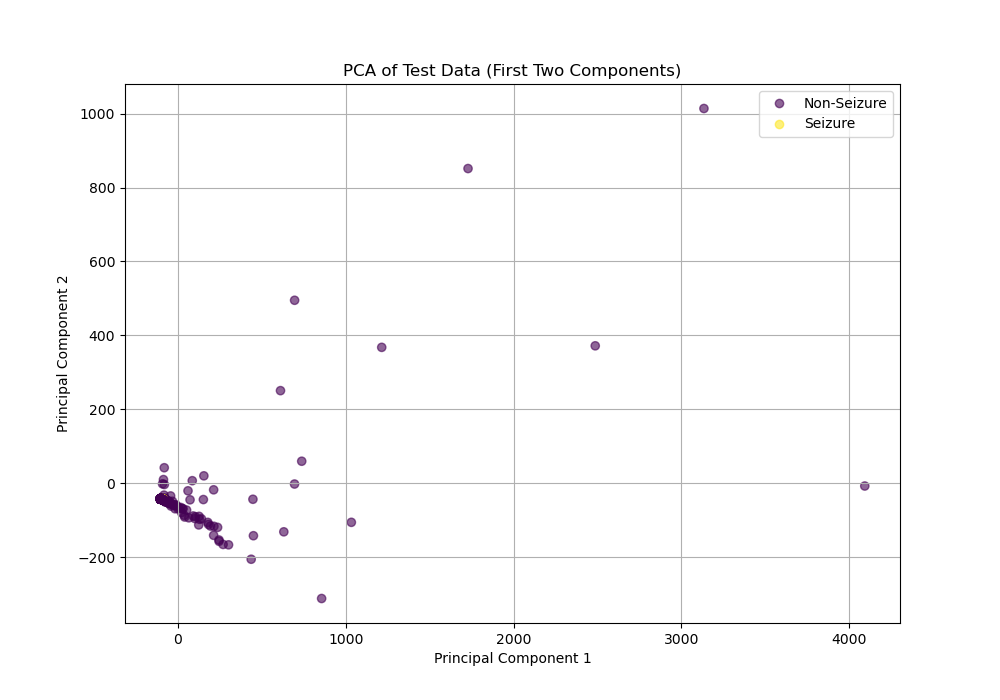

In [36]:
print("\nTraining Random Forest Classifier...")
# A simple, robust classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train_data, train_labels)

print("Evaluating classifier...")
predictions = clf.predict(test_data)

print("\nClassification Report:")
print(classification_report(test_labels, predictions, target_names=['Non-Seizure', 'Seizure']))

# Plotting Confusion Matrix - discuss how feature selection and k-fold cross validation may improve model and else general statistics and etc. from module 1
cm = confusion_matrix(test_labels, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Seizure', 'Seizure'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# a) Visualize PCA components
if DO_PCA and pca.n_components_ >= 2:
    print(f" PCA_WHITEN: {PCA_WHITEN}")
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap='viridis', alpha=0.6)
    plt.title('PCA of Test Data (First Two Components)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Non-Seizure', 'Seizure'])
    plt.grid(True)
    plt.show()

# b) Investigate Feature Relevance
# This is only meaningful if we used engineered features and did not do PCA,
# as PCA transforms the original features.
if not USE_RAW_WINDOW_AS_FEATURE and not DO_PCA:
    importances = clf.feature_importances_
    # We have num_features per channel, let's average them
    avg_importances = np.mean(importances.reshape(num_channels, num_features), axis=0)
    
    feature_names = ['Line Len', 'Energy', 'Pwr Delta', 'Pwr Theta', 'Pwr Alpha', 'Pwr Beta', 'Pwr Gamma']
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, avg_importances)
    plt.title('Average Feature Importance Across All Channels')
    plt.ylabel('Mean Gini Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
